In [1]:
__author__ = "Yasaman Emami"
__email__ = ['emami.yasamann@gmail.com','yasaman.emami@sjsu.edu']

## Import Libraries

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
import re
from nltk.stem.porter import PorterStemmer
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
import gensim
import sys
import string
import logging
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, GRU, Dense, Flatten, Embedding, LSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf
from keras_preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity
from keras.initializers import Constant
from sklearn.metrics import classification_report
from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yasamanemami/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-11-24 20:51:41.220995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read data into a dataframe

In [3]:
df = pd.read_csv('imdb_db.csv')  

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
len(df)

50000

### Distribution of sentiments dist.

<AxesSubplot:xlabel='sentiment', ylabel='count'>

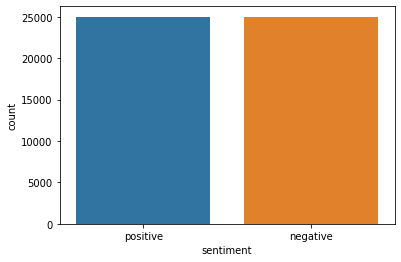

In [6]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

## Convert review column text into lower case (1.d.)

In [7]:
df['review_lower'] = df['review'].str.lower()

In [8]:
type(df["review"][0])

str

## Remove HTML and punctuations (1.c.)

In [9]:
def removeHTML(data):
    data = re.sub("https?://\w+\.\w+\.\w+", " ", data)
    data = re.sub(r"\s+[a-zA-Z]\s+", ' ', data)
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});') 
    return str(re.sub(CLEANR, '', data))
df['remove_html'] = df.apply(lambda x: removeHTML(x['review_lower']), axis=1)

In [10]:
df.head()

,review,sentiment,review_lower,remove_html
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is..."


In [11]:
def punc(data):
    return str(data.translate(str.maketrans('', '', string.punctuation)))

df["punc_removed"] = df.apply(lambda x: punc(x['remove_html']), axis=1)

In [12]:
df.head()

,review,sentiment,review_lower,remove_html,punc_removed
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...


## Tokenize reviews (1.a.)

In [13]:
def tokenize(data):
    return nltk.word_tokenize(data)

df["tokenized"] = df.apply(lambda x: tokenize(x['punc_removed']), axis=1)
df.head()

,review,sentiment,review_lower,remove_html,punc_removed,tokenized
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...,"[i, thought, this, was, wonderful, way, to, sp..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...,"[basically, theres, family, where, little, boy..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...,"[petter, matteis, love, in, the, time, of, mon..."


## Remove stop words (1.b.)

In [14]:
def removeStopWords(data):
    stop_words = set(stopwords.words('english'))
    return [w for w in data if not w in stop_words]

df["remove_stop_words"] = df.apply(lambda x: removeStopWords(x['tokenized']), axis=1)
df.head()   

,review,sentiment,review_lower,remove_html,punc_removed,tokenized,remove_stop_words
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...,"[i, thought, this, was, wonderful, way, to, sp...","[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...,"[basically, theres, family, where, little, boy...","[basically, theres, family, little, boy, jake,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,..."


## Apply stemming and lemmatization (1.e.)

In [15]:
def stemming(data):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(w) for w in data]
df["stemmed"] = df.apply(lambda x: stemming(x['remove_stop_words']), axis=1)

In [16]:
df.head()

,review,sentiment,review_lower,remove_html,punc_removed,tokenized,remove_stop_words,stemmed
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...,"[i, thought, this, was, wonderful, way, to, sp...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...,"[basically, theres, family, where, little, boy...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st..."


In [17]:
def lemmatizing(data):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(w) for w in data]
df["lemmatized"] = df.apply(lambda x: lemmatizing(x['stemmed']), axis=1)

In [18]:
df.head()

,review,sentiment,review_lower,remove_html,punc_removed,tokenized,remove_stop_words,stemmed,lemmatized
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y...","[one, review, mention, watch, 1, oz, episod, y..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonder, littl, product, film, techniqu, unass..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...,"[i, thought, this, was, wonderful, way, to, sp...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...,"[basically, theres, family, where, little, boy...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think...","[basic, there, famili, littl, boy, jake, think..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visual, st..."


## TFIDF+ SVM (2.a.)

#### Prepare data - Detokenize review column

In [19]:
def detokenized(data):
    return TreebankWordDetokenizer().detokenize(data)

df["clean_detokenized"] = df.apply(lambda x: detokenized(x['lemmatized']), axis=1)

In [20]:
df.head()

,review,sentiment,review_lower,remove_html,punc_removed,tokenized,remove_stop_words,stemmed,lemmatized,clean_detokenized
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y...","[one, review, mention, watch, 1, oz, episod, y...",one review mention watch 1 oz episod youll hoo...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...,"[i, thought, this, was, wonderful, way, to, sp...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...,"[basically, theres, family, where, little, boy...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think...","[basic, there, famili, littl, boy, jake, think...",basic there famili littl boy jake think there ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...


In [21]:
type(df["clean_detokenized"][0])

str

#### Apply TFIDF

In [22]:
vectorizer = TfidfVectorizer()
df['review_vectorized'] = vectorizer.fit_transform(df['clean_detokenized'])

#### One hot encoding the sentiments

In [23]:
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['sentiment_encode'] = labelencoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment,review_lower,remove_html,punc_removed,tokenized,remove_stop_words,stemmed,lemmatized,clean_detokenized,review_vectorized,sentiment_encode
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y...","[one, review, mention, watch, 1, oz, episod, y...",one review mention watch 1 oz episod youll hoo...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...,"[i, thought, this, was, wonderful, way, to, sp...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...,"[basically, theres, family, where, little, boy...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think...","[basic, there, famili, littl, boy, jake, think...",basic there famili littl boy jake think there ...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1


In [24]:
X = df['review_vectorized']
y = df['sentiment_encode']

In [25]:
X.shape

(50000,)

In [26]:
X, y = make_classification(n_samples=50000)
X_train , X_test , y_train, y_test = train_test_split(X, y)
clf = svm.SVC(kernel='rbf')
# linear kernel computation
clf.fit(X_train, y_train)

# predict on training examples
predictions = clf.predict(X_test)
# print('ROC-AUC yields ' + str(roc_auc_score(y_test, predictions[:,1])))

In [27]:
svm_acc = accuracy_score(y_test, predictions)
print('TFIDF + SVM accuracy : ' ,svm_acc)

TFIDF + SVM accuracy :  0.95224


In [28]:
'''
source: https://www.kaggle.com/code/hamishdickson/bidirectional-lstm-in-keras-with-glove-embeddings
source: https://www.kaggle.com/code/guichristmann/lstm-classification-model-with-word2vec/notebook
source: https://medium.com/@dhruvshrinet/text-based-classification-with-rnn-with-google-glove-embedding-1ad732099702

'''

'\nsource: https://www.kaggle.com/code/hamishdickson/bidirectional-lstm-in-keras-with-glove-embeddings\nsource: https://www.kaggle.com/code/guichristmann/lstm-classification-model-with-word2vec/notebook\n\n\n'

## Word2Vec (CBoW) + RNN (2.b.)

In [29]:
def plot(history, name):
    # Plotting Loss and Accuracy Graphs
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' Accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [30]:
X = df['clean_detokenized']
y = df['sentiment_encode']
X, y = make_classification(n_samples=50000)
X_train , X_test , y_train, y_test = train_test_split(X, y)

In [31]:
X_test.shape

(12500, 20)

In [32]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class SentimentsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        # select sent
        for review in self.dataset.iloc[:,0]:
            # Make all characters lower-case
            review = review.lower()
            for sentence in review.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words
                
sentences = SentimentsIterator(df)

In [33]:
# Train Word2Vec model with gensim on the dataset
w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=10, workers=8)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Some validation on the quality of the Word2Vec model
print("wonderful: ", w2v_model.wv.most_similar('wonderful', topn=3))
print("crap: ", w2v_model.wv.most_similar('crap', topn=3))

Vocabulary Size: 29337 - Embedding Dim: 100
wonderful:  [('fantastic', 0.8572867512702942), ('marvelous', 0.8354805111885071), ('terrific', 0.8223742246627808)]
crap:  [('garbage', 0.8893814086914062), ('rubbish', 0.8211306929588318), ('junk', 0.8086460828781128)]


In [34]:
def word2token(word):
    try:
        return w2v_model.wv.key_to_index[word]
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

In [35]:
from keras_preprocessing.sequence import pad_sequences


# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 100

# Samples of categories with less than this number of samples will be ignored
DROP_THRESHOLD = 10000

class SequenceIterator:
    def __init__(self, dataset, drop_threshold, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.sentiment, self.ccount = np.unique(dataset.sentiment, return_counts=True)
        
        self.seq_length = seq_length
        
        # Samples of categories with less than this number of samples will be ignored
        self.drop_categos = []
        for sentiment, count in zip(self.sentiment, self.ccount):
            if count < drop_threshold:
                self.drop_categos.append(sentiment)
        
        # Remaining categories
        self.sentiment = np.setdiff1d(self.sentiment, self.drop_categos)
        
    def __iter__(self):
        for review, sentiment in zip(self.dataset.clean_detokenized, self.dataset.iloc[:, 1]):
            if sentiment in self.drop_categos:
                continue
            
            # Make all characters lower-case
            review = review.lower()
            
            # Clean string of all punctuation
            review = review.translate(self.translator)

            words = np.array([word2token(w) for w in review.split(' ')[:self.seq_length] if w != ''])
                                
            yield (words, sentiment)

sequences = SequenceIterator(df, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)


# Used for generating the labels in the set
sentiment_dict = {k: v for k, v in zip(sequences.sentiment, range(len(sequences.sentiment)))}

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(sentiment_dict[c])
    
# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

print(set_x.shape)
print(set_y.shape)

(50000, 100)
(50000,)


In [36]:
VALID_PER = 0.15 # Percentage of the whole set that will be separated for validation

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
X_train = set_x[random_i[:n_train]]
y_train = set_y[random_i[:n_train]]
X_test = set_x[random_i[n_train:n_train+n_val]]
y_test = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(X_train.shape, y_train.shape))
print("Val Shapes - X: {} - Y: {}".format(X_test.shape, y_test.shape))


Train Shapes - X: (42500, 100) - Y: (42500,)
Val Shapes - X: (7500, 100) - Y: (7500,)


2022-11-24 20:59:19.715531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
665/665 [==============================] - 21s 30ms/step - loss: 0.7026 - accuracy: 0.5173 - val_loss: 0.6876 - val_accuracy: 0.5424
Epoch 2/10
665/665 [==============================] - 19s 29ms/step - loss: 0.6589 - accuracy: 0.6139 - val_loss: 0.6233 - val_accuracy: 0.6997
Epoch 3/10
665/665 [==============================] - 19s 29ms/step - loss: 0.6228 - accuracy: 0.6724 - val_loss: 0.6178 - val_accuracy: 0.6900
Epoch 4/10
665/665 [==============================] - 19s 29ms/step - loss: 0.6163 - accuracy: 0.6792 - val_loss: 0.6807 - val_accuracy: 0.5560
Epoch 5/10
665/665 [==============================] - 19s 29ms/step - loss: 0.6250 - accuracy: 0.6620 - val_loss: 0.6149 - val_accuracy: 0.7079
Epoch 6/10
665/665 [==============================] - 19s 29ms/step - loss: 0.6092 - accuracy: 0.6841 - val_loss: 0.6168 - val_accuracy: 0.6873
Epoch 7/10
665/665 [==============================] - 19s 29ms/step - loss: 0.6248 - accuracy: 0.6511 - val_loss: 0.6479 - val_accuracy:

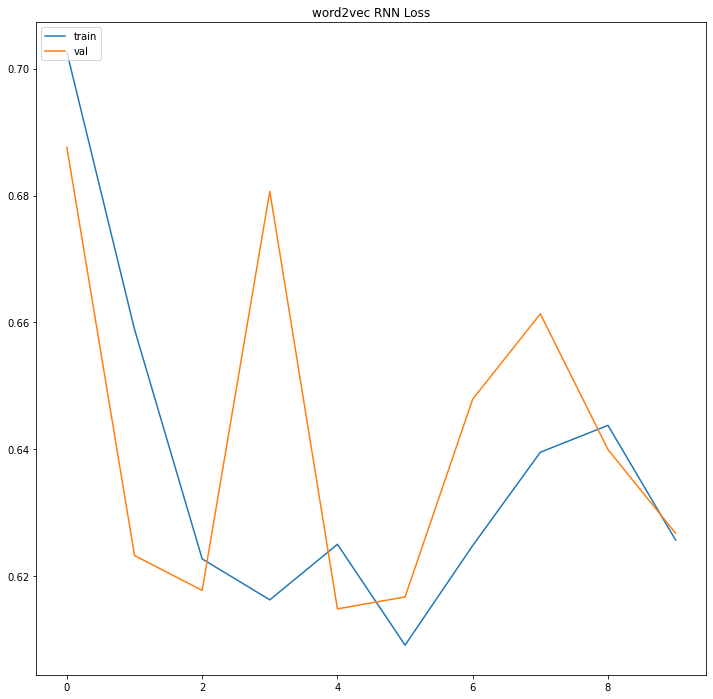

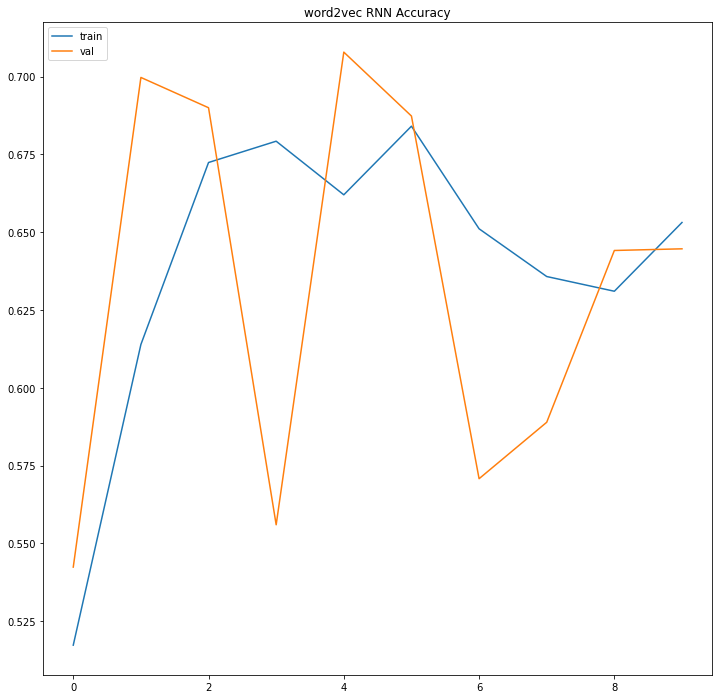

235/235 [==============================] - 2s 7ms/step
word2vec + RNN accuracy:
 
{'0': {'precision': 0.6224719101123596, 'recall': 0.7376830892143809, 'f1-score': 0.6751980499695308, 'support': 3755}, '1': {'precision': 0.6770491803278689, 'recall': 0.5514018691588785, 'f1-score': 0.6077998528329654, 'support': 3745}, 'accuracy': 0.6446666666666667, 'macro avg': {'precision': 0.6497605452201143, 'recall': 0.6445424791866297, 'f1-score': 0.6414989514012481, 'support': 7500}, 'weighted avg': {'precision': 0.6497241603733038, 'recall': 0.6446666666666667, 'f1-score': 0.6415438835326726, 'support': 7500}}


In [37]:
model = Sequential(name="W2v-RNN")

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(SimpleRNN(units=32))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(2,activation='sigmoid'))  # sigmod for bin. classification.

# model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
# history = model.fit(train_x,train_y,epochs=5,batch_size=64,validation_data=(val_x, val_y))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history_w2v_rnn = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)
plot(history_w2v_rnn, "word2vec RNN")
y_hat = model.predict(X_test)

# w2v_rnn_acc = accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))
# glove_lstm_acc = accuracy_score(y_test, y_hat)
w2v_rnn_acc = classification_report(y_test, np.argmax(y_hat, axis=1), output_dict=True)
print("word2vec + RNN accuracy:\n ")

print(w2v_rnn_acc)


## Word2Vec (CBoW) + LSTM (2.c.)

Model: "word2vec-lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          2933700   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 402       
                                                                 
Total params: 3,094,902
Trainable params: 161,202
Non

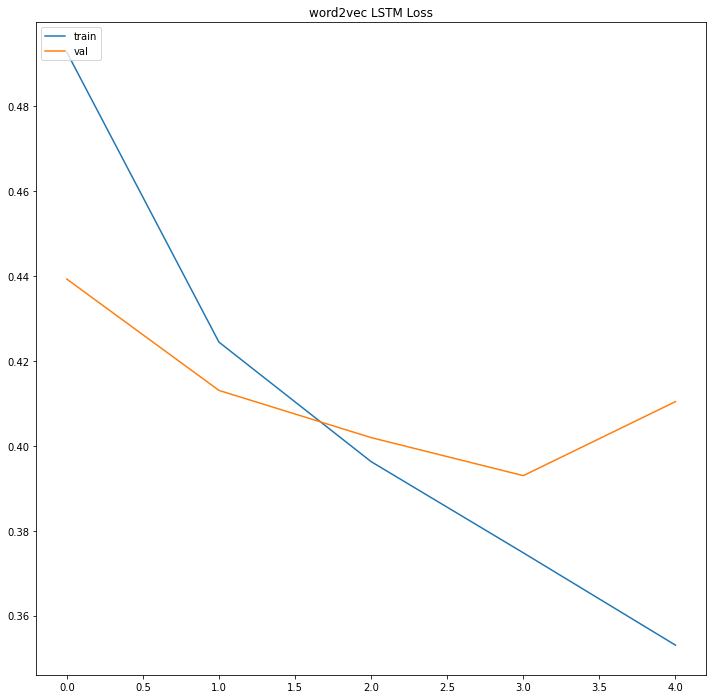

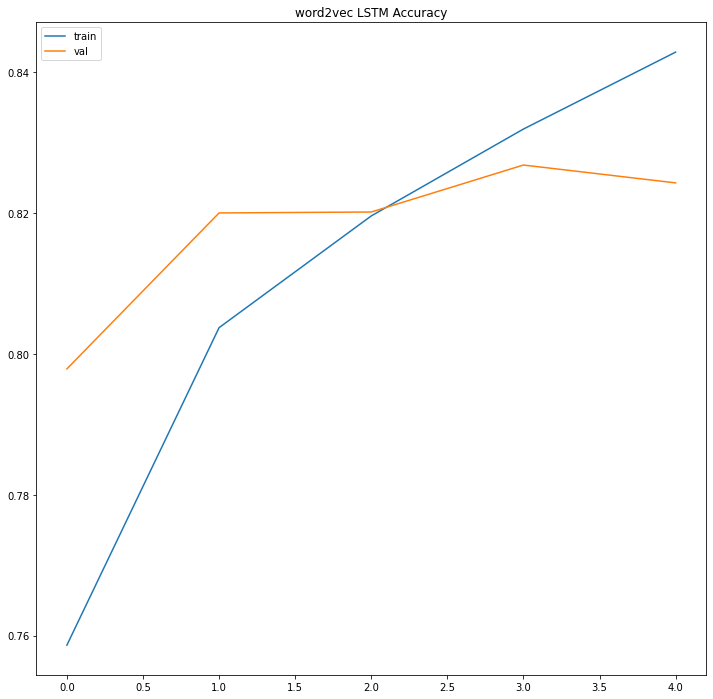

235/235 [==============================] - 9s 29ms/step
word2vec + LSTM accuracy:
{'0': {'precision': 0.8660258335836588, 'recall': 0.7677762982689748, 'f1-score': 0.8139469226425748, 'support': 3755}, '1': {'precision': 0.790937425077919, 'recall': 0.8809078771695594, 'f1-score': 0.8335017685699849, 'support': 3745}, 'accuracy': 0.8242666666666667, 'macro avg': {'precision': 0.8284816293307888, 'recall': 0.8243420877192671, 'f1-score': 0.8237243456062799, 'support': 7500}, 'weighted avg': {'precision': 0.8285316882697927, 'recall': 0.8242666666666667, 'f1-score': 0.8237113090423283, 'support': 7500}}


In [38]:
model = Sequential(name="word2vec-lstm")
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100)))
# model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(units=2, activation='sigmoid'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history_w2v_lstm = model.fit(X_train, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)
plot(history_w2v_lstm, "word2vec LSTM")
y_hat = model.predict(X_test)
# w2v_lstm_acc = accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))
# glove_lstm_acc = accuracy_score(y_test, y_hat)
print("word2vec + LSTM accuracy:")
w2v_lstm_acc = classification_report(y_test, np.argmax(y_hat, axis=1), output_dict=True)
print(w2v_lstm_acc)


## Glove + RNN (2.d.)

In [39]:
df['l'] = df.iloc[:, 0].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(df.l.mean()))
print("max length of sentence: " + str(df.l.max()))
print("std dev length of sentence: " + str(df.l.std()))

mean length of sentence: 231.14594
max length of sentence: 2470
std dev length of sentence: 171.32641902623635


In [40]:
# code for Glove word embedding


sequence_length = 100
max_features = 20000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(df.clean_detokenized.values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(df.clean_detokenized.values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(df['sentiment']).values

# lets keep a couple of thousand samples back as a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))


embeddings_index = {}
f = open( 'glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


# print("Dense vector for first word is => ",
	# embedding_matrix_vocab[1])


test set size 5000


In [41]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

num_words = min(max_features, len(word_index)) +1
print(num_words)

embedding_dim = 100

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

Found 182120 unique tokens.
20001


In [42]:
embedding_matrix.shape

(20001, 100)

In [43]:
from keras.datasets import imdb
((xtrain,ytrain),(xtest,ytest)) = imdb.load_data(num_words=10000)

In [44]:
glove_dir = 'glove.6B/glove.6B.100d.txt'

embedings = {}
with open(glove_dir) as f:
    data = f.readlines()
    
embeddings = {}
for line in data:
    word = line.split()[0]
    embeddings[word] = np.asarray(line.split()[1:],dtype='float32')

In [45]:
max_features = 10000
max_len = 1000
((xtrain,ytrain),(xtest,ytest)) = imdb.load_data(num_words=max_features)
xtrain = pad_sequences(xtrain,maxlen=max_len)
xtest = pad_sequences(xtest,maxlen=max_len)

In [46]:
embedding_matrix = np.zeros((max_features,embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # we found the word - add that words vector to the matrix
            embedding_matrix[i] = embedding_vector
   

Epoch 1/5
391/391 [==============================] - 80s 202ms/step - loss: 0.6921 - accuracy: 0.5375 - val_loss: 0.6741 - val_accuracy: 0.5568
Epoch 2/5
391/391 [==============================] - 79s 201ms/step - loss: 0.6616 - accuracy: 0.5774 - val_loss: 0.6564 - val_accuracy: 0.5859
Epoch 3/5
391/391 [==============================] - 79s 201ms/step - loss: 0.6448 - accuracy: 0.6016 - val_loss: 0.6432 - val_accuracy: 0.6017
Epoch 4/5
391/391 [==============================] - 78s 200ms/step - loss: 0.6281 - accuracy: 0.6220 - val_loss: 0.6694 - val_accuracy: 0.5784
Epoch 5/5
391/391 [==============================] - 79s 201ms/step - loss: 0.6163 - accuracy: 0.6408 - val_loss: 0.6178 - val_accuracy: 0.6373


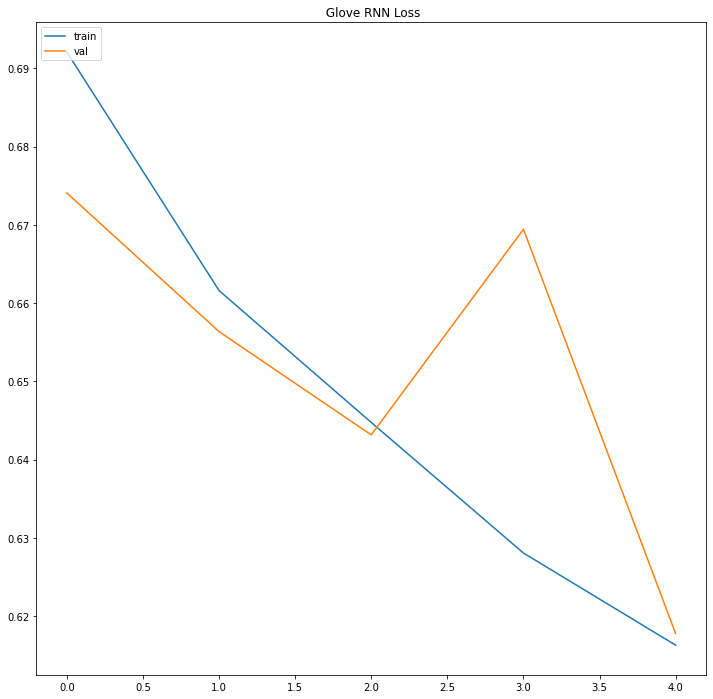

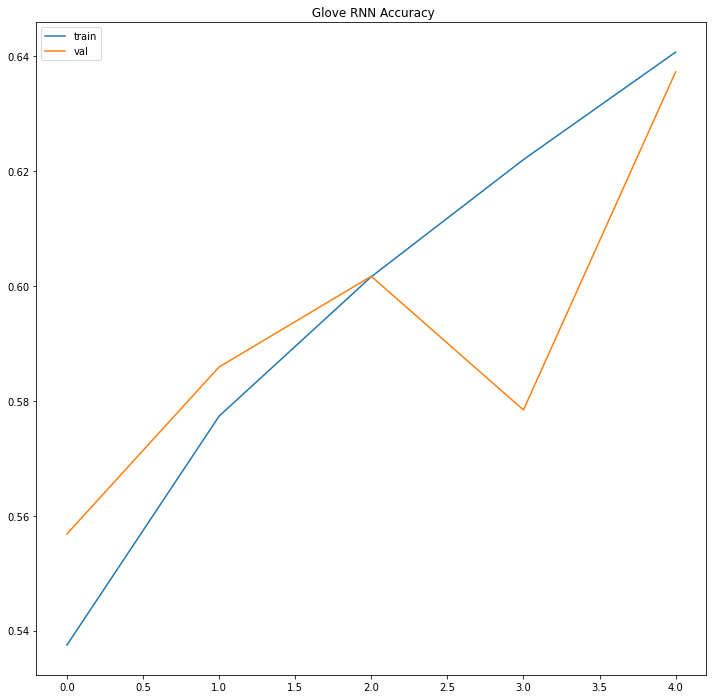

782/782 [==============================] - 32s 41ms/step
Glove + RNN: 
 0.63252


In [47]:
n_categories = 2

model = Sequential(name="Glove-RNN")

# Keras Embedding layer with glove initialization
model.add(Embedding(max_features,
                    100,
                    input_length=max_len))

model.add(SimpleRNN(units=32))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.50))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(2,activation='sigmoid'))  # sigmod for bin. classification.

# model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
# history = model.fit(train_x,train_y,epochs=5,batch_size=64,validation_data=(val_x, val_y))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_glove_rnn = model.fit(xtrain, ytrain, epochs=5, batch_size=64,
                    validation_data=(xtest, ytest), verbose=1)
plot(history_glove_rnn, " Glove RNN")
y_hat = model.predict(xtest)
glove_rnn_acc = accuracy_score(list(map(lambda x: np.argmax(x), ytest)), list(map(lambda x: np.argmax(x), y_hat)))

# glove_rnn_acc = accuracy_score(y_test, y_hat)
# glove_rnn_acc = classification_report(y_test, np.argmax(y_hat, axis=1), output_dict=True)
print("Glove + RNN: \n", glove_rnn_acc)


## Glove + LSTM (2.e.)

Model: "Glove-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 402       
                                                                 
Total params: 1,161,202
Trainable params: 161,202
Non-tr

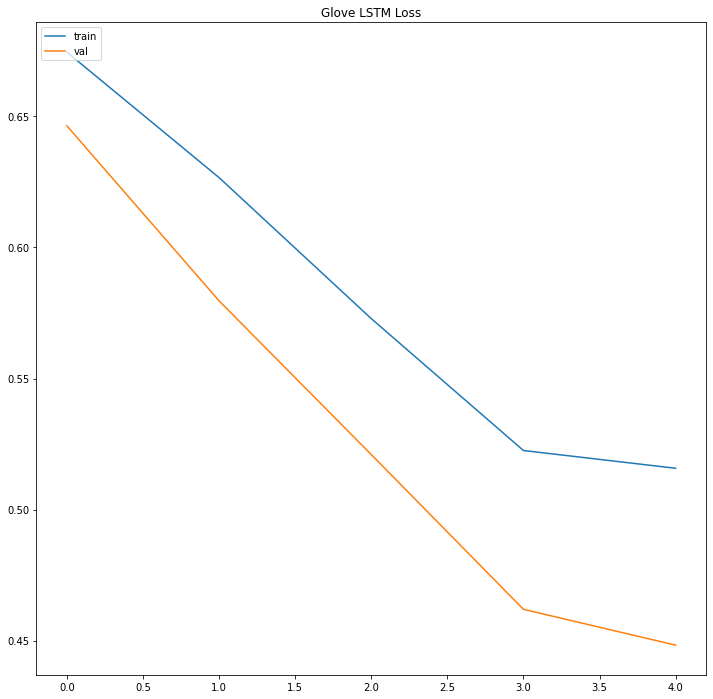

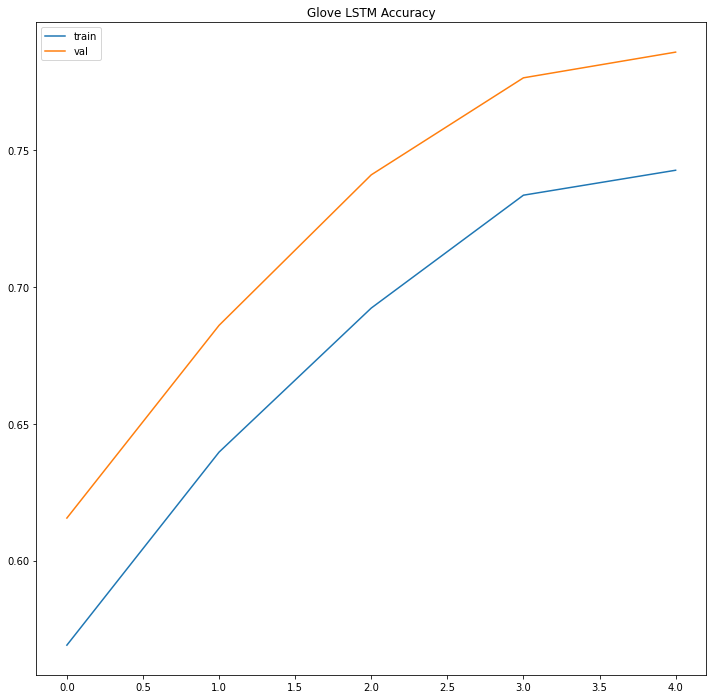

782/782 [==============================] - 194s 247ms/step
Glove + LSTM 0.409


In [49]:
model = Sequential(name="Glove-LSTM")
model.add(Embedding(max_features,
                    100,
                    input_length=max_len))

model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100)))
# model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(units=2, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history_glove_lstm = model.fit(xtrain, ytrain, epochs=5, batch_size=64,
                    validation_data=(xtest, ytest), verbose=1)
plot(history_glove_lstm, "Glove LSTM")
y_hat = model.predict(xtest)
# glove_lstm_acc = accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))
# glove_lstm_acc = accuracy_score(y_test, y_hat)
# glove_lstm_acc = classification_report(y_test, np.argmax(y_hat, axis=1), output_dict=True)
glove_lstm_acc = accuracy_score(list(map(lambda x: np.argmax(x), ytest)), list(map(lambda x: np.argmax(x), y_hat)))
print("Glove + LSTM", glove_lstm_acc)

In [50]:
data = {'TFIDF + SVM acc': svm_acc, 'w2vec + RNN acc': w2v_rnn_acc['accuracy'], 'w2vec + LSTM acc': w2v_lstm_acc['accuracy'], 'Glove + RNN acc': glove_rnn_acc, 'Glove + LSTM acc': glove_lstm_acc}
pd.DataFrame(data, index=['Accuracy'])

,TFIDF + SVM acc,w2vec + RNN acc,w2vec + LSTM acc,Glove + RNN acc,Glove + LSTM acc
Accuracy,0.95224,0.644667,0.824267,0.63252,0.409


In [51]:
df.head()

,review,sentiment,review_lower,remove_html,punc_removed,tokenized,remove_stop_words,stemmed,lemmatized,clean_detokenized,review_vectorized,sentiment_encode,l
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y...","[one, review, mention, watch, 1, oz, episod, y...",one review mention watch 1 oz episod youll hoo...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1,307
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...,a wonderful little production. the filming tec...,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1,162
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,i thought this was wonderful way to spend time...,"[i, thought, this, was, wonderful, way, to, sp...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1,166
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's family where little boy (jak...,basically theres family where little boy jake ...,"[basically, theres, family, where, little, boy...","[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think...","[basic, there, famili, littl, boy, jake, think...",basic there famili littl boy jake think there ...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter mattei's ""love in the time of money"" is...",petter matteis love in the time of money is vi...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...,"(0, 144222)\t0.04834021644705482\n (0, 4012...",1,230


In [52]:
X = df.clean_detokenized
y = df.sentiment_encode

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [54]:
X_train=np.array(X_train.values.tolist())
X_test=np.array(X_test.values.tolist())

In [55]:
tokenizer = Tokenizer()

In [56]:
tokenizer.fit_on_texts(X_train)

In [57]:
word_index=tokenizer.word_index

In [58]:
vocab_size = len(word_index)+1

In [59]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Keras Embedding Layer

In [60]:
maxlen = 100
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [61]:
model = Sequential()
# all words in the vocub will have 30-dimensional vector (word embedding)
# you can initialize the weights of embedding parameters as we did for ANN/CNN
embedding_layer = Embedding(vocab_size, 30,
                            input_length=maxlen, 
                            embeddings_initializer='ones')

model.add(embedding_layer)

In [62]:
#example: embedding the first review 
first_review_without_pad = X_train[0]
first_review_with_pad = X_train_pad[0]

In [63]:
output_1st_review_without_pad = model.predict(first_review_without_pad)
output_1st_review_with_pad = model.predict(first_review_with_pad)

4/4 [==============================] - 0s 1ms/step


In [64]:
pd.DataFrame(output_1st_review_without_pad)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
119,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
120,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
121,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [65]:
model.add(LSTM(units=32, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [67]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 30)           4680240   
                                                                 
 lstm_2 (LSTM)               (None, 32)                8064      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,688,337
Trainable params: 4,688,337
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
model.fit(X_train_pad, y_train, 
          batch_size=128, 
          epochs=20, 
          verbose=1, 
          validation_data=(X_test_pad, y_test))

Epoch 1/20
313/313 [==============================] - 45s 136ms/step - loss: 0.6982 - acc: 0.5041 - val_loss: 0.6932 - val_acc: 0.5043
Epoch 2/20
313/313 [==============================] - 45s 143ms/step - loss: 0.6943 - acc: 0.5037 - val_loss: 0.6925 - val_acc: 0.5044
Epoch 3/20
313/313 [==============================] - 44s 139ms/step - loss: 0.6935 - acc: 0.5063 - val_loss: 0.6923 - val_acc: 0.5043
Epoch 4/20
313/313 [==============================] - 43s 136ms/step - loss: 0.6927 - acc: 0.5138 - val_loss: 0.6926 - val_acc: 0.4957
Epoch 5/20
313/313 [==============================] - 43s 138ms/step - loss: 0.6918 - acc: 0.5167 - val_loss: 0.6896 - val_acc: 0.5190
Epoch 6/20
313/313 [==============================] - 43s 137ms/step - loss: 0.6839 - acc: 0.5501 - val_loss: 0.6331 - val_acc: 0.6175
Epoch 7/20
313/313 [==============================] - 43s 137ms/step - loss: 0.5775 - acc: 0.6995 - val_loss: 0.4154 - val_acc: 0.8291
Epoch 8/20
313/313 [==============================] - 4

In [69]:
y_hat = model.predict(X_test_pad)

313/313 [==============================] - 4s 11ms/step


In [70]:
keras_embed_acc = classification_report(y_test, np.argmax(y_hat, axis=1), output_dict=True)
print("keras embedding: ", keras_embed_acc)

Glove + LSTM {'0': {'precision': 0.5043, 'recall': 1.0, 'f1-score': 0.6704779631722395, 'support': 5043}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4957}, 'accuracy': 0.5043, 'macro avg': {'precision': 0.25215, 'recall': 0.5, 'f1-score': 0.33523898158611976, 'support': 10000}, 'weighted avg': {'precision': 0.25431848999999995, 'recall': 0.5043, 'f1-score': 0.3381220368277604, 'support': 10000}}


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
word_embeddings = embedding_layer.get_weights()[0]

In [72]:
# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
embedding_4_each_words = {w:word_embeddings[idx] for w, idx in word_index.items()}

In [73]:
simil = cosine_similarity(word_embeddings, embedding_4_each_words['good'].reshape(1, -1))

In [74]:
n = 5
top_n_similar = sorted(range(len(simil)), key=lambda i: simil[i])[-n-1:-1]

In [75]:
for word, vector in embedding_4_each_words.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    for i in range (n):
        if np.array_equal(vector,word_embeddings[top_n_similar[i]]):
            print(word, simil[top_n_similar[i]])

jack [0.99675786]
to [0.9965871]
clairvoy [0.99651676]
outstay [0.99675536]
mceveeti [0.9965618]


In [76]:
top_n_similar

[13501, 25496, 9603, 19848, 626]

In [77]:
simil

array([[0.9100807 ],
       [0.95787895],
       [0.97657   ],
       ...,
       [0.9235605 ],
       [0.97154987],
       [0.9812816 ]], dtype=float32)